## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
patience = [10 , 25]

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for p in patience:
    model = build_mlp(x_train.shape[1:])
    opt = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=[x_test, y_test],
              callbacks=[EarlyStopping(monitor='val_accuracy', patience=p, verbose=1)])
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-p-%s" % str(p)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
49/49 [==============================] - ETA: 0s - loss: 2.2348 - accuracy: 0.2645WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000211600E3B88> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

Epoch 19/50
49/49 [==============================] - 5s 95ms/step - loss: 1.1172 - accuracy: 0.6169 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 20/50
49/49 [==============================] - 5s 94ms/step - loss: 1.0949 - accuracy: 0.6241 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 21/50
49/49 [==============================] - 6s 129ms/step - loss: 1.0787 - accuracy: 0.6297 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 22/50
49/49 [==============================] - 7s 142ms/step - loss: 1.0591 - accuracy: 0.6376 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 23/50
49/49 [==============================] - 6s 130ms/step - loss: 1.0391 - accuracy: 0.6471 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 24/50
49/49 [==============================] - 5s 105ms/step - loss: 1.0171 - accuracy: 0.6548 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 25/50
49/49 [==============================] - 6s 114ms/step - loss: 0.9962 - accuracy: 0.

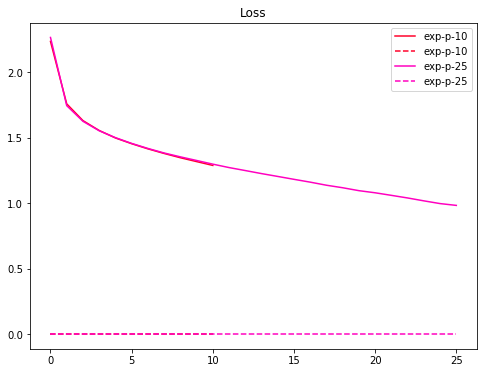

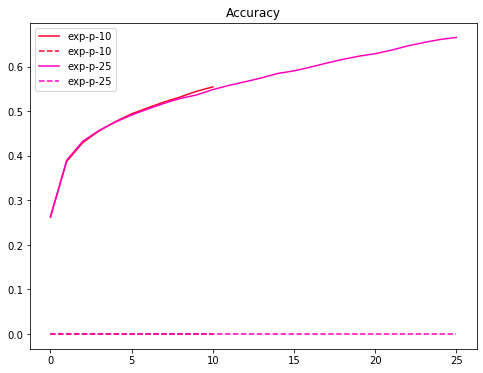

In [8]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 2

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()